In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Starter
* Data -> Build Dataset -> split dataset
* vocab
* init_MLP_params
* training
* loss
* sampling

In [2]:
words = open("names.txt").read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [3]:
vocab = sorted(set(''.join(words)))

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos) # Used for initiate emb lookup table

In [4]:
block_size = 3
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context), ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
train_idx = int(0.8 * len(words))
val_idx   = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:train_idx])
x_val  , y_val   = build_dataset(words[train_idx:val_idx])
x_test , y_test  = build_dataset(words[val_idx:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
emb_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dim)              , generator=g)
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim                        , generator=g)
W2 = torch.randn((hidden_dim, vocab_size)          , generator=g)
b2 = torch.randn(vocab_size                        , generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"Parameter number: {sum([p.nelement() for p in parameters])}")
for p in parameters:
    p.requires_grad = True

Parameter number: 11897


In [6]:
max_steps  = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Forward
    idx = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = x_train[idx], y_train[idx] 
    
    emb = C[Xb]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000  else 0.01
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad
            
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.7667
  20000/ 200000: 2.6773
  30000/ 200000: 2.7836
  40000/ 200000: 2.0416
  50000/ 200000: 2.6894
  60000/ 200000: 2.2941
  70000/ 200000: 2.1137
  80000/ 200000: 2.3393
  90000/ 200000: 2.1892
 100000/ 200000: 2.0250
 110000/ 200000: 2.3710
 120000/ 200000: 2.0257
 130000/ 200000: 2.3571
 140000/ 200000: 2.2188
 150000/ 200000: 2.1529
 160000/ 200000: 2.1815
 170000/ 200000: 1.7772
 180000/ 200000: 2.0281
 190000/ 200000: 1.7446


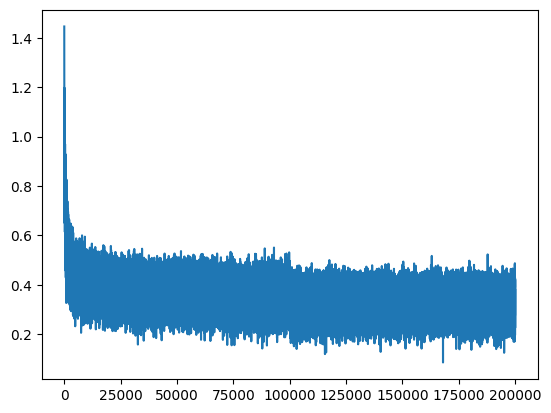

In [7]:
plt.plot(torch.arange(len(lossi)), lossi)

In [8]:
def split_loss(mode="train"):
    x, y = {
        "train": (x_train, y_train),
        "val"  : (x_val  , y_val),
        "test" : (x_test , y_test)
    }[mode]
    x = x_train if mode == "train" else x_val
    y = y_train if mode == "train" else y_val
    
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{mode} loss over the entire dataset is: {loss.item()}")
    
split_loss("train")
split_loss("val")

train loss over the entire dataset is: 2.1256096363067627
val loss over the entire dataset is: 2.169816732406616


In [9]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sampling
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join([itos[i] for i in out]))

carlah.
amelle.
khi.
mili.
taty.
skanden.
jazhuen.
den.
art.
kaqui.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quinn.
salin.
alianni.
wazthoniearynix.
kaellinsley.
